In [1]:
import numpy as np
import pandas as pd

In [21]:
dataset= pd.read_excel("dataset/jalsh_dataset.xlsx", sheet_name="data", parse_dates=True, index_col=0, header=[0, 1])
targets = pd.read_excel("dataset/data_ratings.xlsx")

In [26]:
targets = pd.read_excel("d.xlsx",index_col=0)

In [28]:
targets.to_excel("dataset/jalsh_dataset_targets.xlsx")

Index(['RTG_MOODY_LONG_TERM', 'RTG_MDY_OUTLOOK', 'RTG_MOODY_LONG_TERM_DATE',
       'RTG_SP_LT_LC_ISSUER_CREDIT', 'RTG_SP_OUTLOOK',
       'RTG_SP_LT_LC_ISS_CRED_RTG_DT', 'RSK_BB_ISSUER_DEFAULT', 'RATINGS',
       'RTG_MOODY_LONG_TERM_MAPPED', 'RTG_MOODY_LONG_TERM_MAPPED_SCORES',
       'RTG_SP_LT_LC_ISSUER_CREDIT_MAPPED',
       'RTG_SP_LT_LC_ISSUER_CREDIT_MAPPED_SCORES',
       'RSK_BB_ISSUER_DEFAULT_MAPPED', 'RSK_BB_ISSUER_DEFAULT_MAPPED_SCORES'],
      dtype='object')

<Axes: >

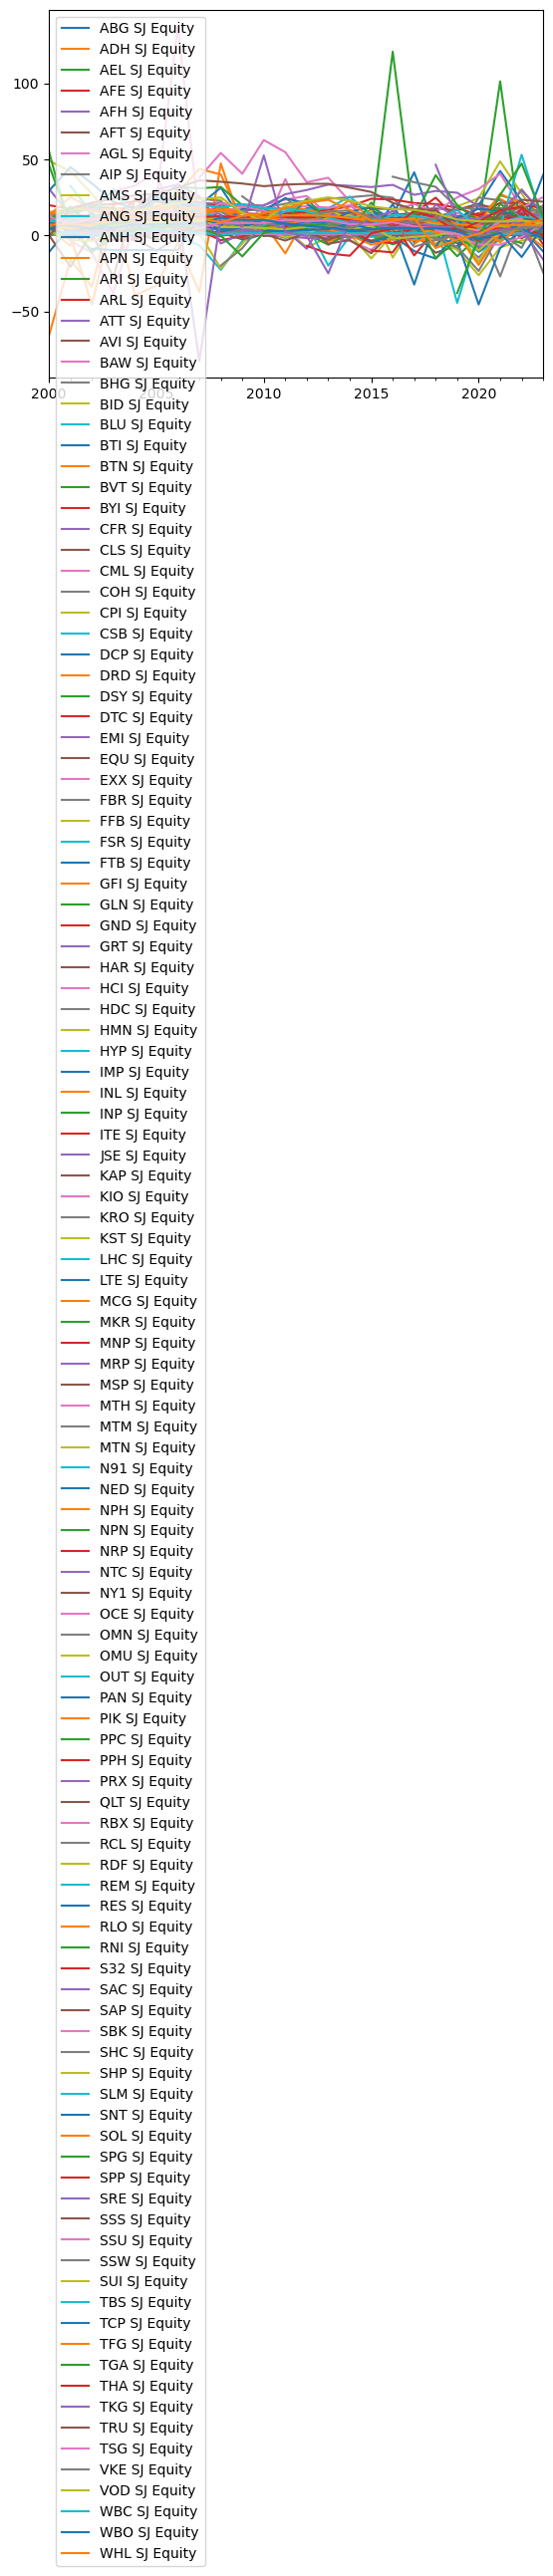

In [11]:
df.plot()

In [21]:
y = targets[targets.index.str.endswith("SJ Equity")]["numeric_rating"]

In [27]:
X = data[y.index].mean().unstack()

In [46]:
X = X.fillna(X.mean())

In [80]:
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.tree import DecisionTreeRegressor
from scipy.optimize import nnls

In [81]:
model = Lasso(positive=True)

In [82]:
model.fit(X, y)

Lasso(positive=True)

In [83]:
model.score(X, y)

0.34021245850049475

In [84]:
model.predict(X)

array([5.74750672, 5.59723092, 5.87558498, 5.77528039, 5.81399107,
       5.77822432, 5.87390352, 5.60418804, 5.94949075, 6.06108728,
       7.42337882, 5.67720556, 6.12216069, 6.18404382, 5.79172965,
       5.54307765, 5.88439658, 6.54966041, 5.96263383, 5.80361434,
       5.78518952, 5.99689246, 5.67415994, 5.70202354, 5.81002716,
       6.72211303, 6.19285393, 6.09835108])

In [85]:
weights, residuals = nnls(X, y)

In [86]:
pd.DataFrame(weights, X.columns).replace(0, np.nan).dropna()

,0
Dates,
ASSET_TO_EQY,0.385938
BS_TOTAL_AVAIL_LINE_OF_CREDIT,0.000052
CASH_TO_TOT_ASSET,0.093351
CFO_TO_TOT_DEBT,0.231022
EBITDA_TO_REVENUE,0.001648
EBITDA_TO_TOT_INT_EXP,0.008140
SALES_GROWTH,0.034198
SALES_TO_INVENT,0.021561
SALES_TO_TOT_ASSET,0.944712


In [78]:
(weights @ X.T).tail()

SAP SJ Equity    6.681988
SNT SJ Equity    5.416486
SOL SJ Equity    6.895689
SSW SJ Equity    6.419577
TKG SJ Equity    5.517018
dtype: float64

In [79]:
y.tail()

SAP SJ Equity    6.5
SNT SJ Equity    6.5
SOL SJ Equity    6.5
SSW SJ Equity    6.5
TKG SJ Equity    6.5
Name: numeric_rating, dtype: float64

In [87]:
class CreditModel:
    SCALES = {
        'Revenue': [60000, 30000, 10000, 5000, 1500, 500, 200, 0],
        'EBITA Margin': [50, 35, 25, 20, 15, 10, 5, 0],
        'Debt / EBITDA': [0.5, 1, 2, 3, 4.5, 6.5, 9, float('inf')],
        'EBITA / Interest Expense': [25, 15, 10, 6, 3, 1, 0, 0],
        'RCF / Net Debt': [80, 60, 40, 25, 15, 7.5, 2.5, 0],
        'Demand Characteristics': ['Highly reliable', 'Very high', 'High', 'Significant', 'Some', 'Limited', 'Very recent', 'New'],
        'Competitive Profile': ['Dominant', 'Market share reflects oligopolistic industry', 'Leading', 'Among market share leaders', 'Among top providers', 'Local or niche player', 'Small player', 'Very small player'],
        'Financial Policy': ['Very conservative', 'Conservative', 'Predictable', 'Balanced', 'Somewhat aggressive', 'Aggressive', 'Elevated risk of debt restructuring', 'Elevated risk of debt restructuring']
    }

    WEIGHTS = {
        'Revenue': 0.2,
        'EBITA Margin': 0.1,
        'Debt / EBITDA': 0.15,
        'EBITA / Interest Expense': 0.15,
        'RCF / Net Debt': 0.1,
        'Demand Characteristics': 0.15,
        'Competitive Profile': 0.05,
        'Financial Policy': 0.1
    }

    RATINGS = ['Aaa', 'Aa1', 'Aa2', 'Aa3', 'A1', 'A2', 'A3', 'Baa1', 'Baa2', 'Baa3', 'Ba1', 'Ba2', 'Ba3', 'B1', 'B2', 'B3', 'Caa1', 'Caa2', 'Caa3', 'Ca']

    def __init__(self, metrics):
        self.metrics = metrics

    def map_metric_to_rating(self, metric, value):
        scale = self.SCALES[metric]
        return next((rating for rating, threshold in zip(self.RATINGS, scale) if value >= threshold), 'Ca')

    def calculate_score(self):
        scores = [self.RATINGS.index(self.map_metric_to_rating(metric, value)) * self.WEIGHTS[metric] for metric, value in self.metrics.items()]
        return sum(scores)

    def get_rating(self):
        score = self.calculate_score()
        return next((rating for rating, threshold in zip(self.RATINGS, range(1, 21)) if score < threshold), 'Ca')

In [96]:
metrics = {
    'Revenue': 800,
    'EBITA Margin': 2,
    'Debt / EBITDA': 200000.5,
    'EBITA / Interest Expense': 0.01,
    'RCF / Net Debt': 1,
    'Demand Characteristics': 'Significant',
    'Competitive Profile': 'Among market share leaders',
    'Financial Policy': 'Balanced'
}

model = CreditModel(metrics)
rating = model.get_rating()
print(f"The credit rating is: {rating}")

The credit rating is: Aa3


In [105]:
import json

In [106]:
with open("hello_credit_config.json", "r") as f:
    file = json.load(f)

In [109]:
METRICS = file["credit_model_config"]

In [118]:

# Financial ratios for a company
financial_ratios = {
    "oper_margin": 35,
    "tot_debt_to_tot_eqy": 50,
    "tot_debt_to_ebitda": 2.5,
    "ebitda_to_tot_int_exp": 8,
    "return_on_asset": 0.07,
    "asset_turnover": 1.2
}

# Create an instance of the CreditRatingCalculator
calculator = CreditRatingCalculator(financial_ratios)

# Calculate the credit rating
credit_rating = calculator.calculate_credit_rating()

# Print the credit rating
print(f"The credit rating for the company is: {credit_rating}")

AttributeError: 'CreditRatingCalculator' object has no attribute '_calculate_weighted_score'

In [197]:
features = pd.read_excel("dataset/features.xlsx", index_col=0)
targets = pd.read_excel("dataset/target.xlsx", index_col=0)
features.columns = features.columns.str.lower()

In [190]:
targets = targets['numeric_rating']

In [191]:
X = features[features.index.str.endswith("SJ Equity")]

In [161]:
X = X.dropna()

In [199]:
y

AGL SJ Equity    5.5
ANG SJ Equity    5.5
ANH SJ Equity    4.5
BAW SJ Equity    6.5
BHG SJ Equity    4.5
BVT SJ Equity    6.5
GFI SJ Equity    5.5
MNP SJ Equity    5.5
SAP SJ Equity    6.5
SOL SJ Equity    6.5
TKG SJ Equity    6.5
Name: numeric_rating, dtype: float64

In [198]:
#X = X.T.dropna().T
y = y.loc[X.index]

KeyError: "['BTI SJ Equity', 'CFR SJ Equity', 'DSY SJ Equity', 'FFB SJ Equity', 'FSR SJ Equity', 'GLN SJ Equity', 'GRT SJ Equity', 'HMN SJ Equity', 'MSP SJ Equity', 'MTN SJ Equity', 'NRP SJ Equity', 'PPH SJ Equity', 'PRX SJ Equity', 'RDF SJ Equity', 'S32 SJ Equity', 'SNT SJ Equity', 'SSW SJ Equity'] not in index"

In [163]:
models = LinearRegression().fit(X, y)
models.score(X, y)

1.0

In [164]:
np.round(models.coef_*1e2, 0)

array([ 0., -0.,  0.,  0.,  0.,  0., -0.,  2.,  1.,  0.,  0.,  0.,  0.,
       -2., -0., -1.,  2., -1., -2., -0.,  0., -0.,  0.,  0.,  0.,  2.])

In [167]:
X.columns

Index(['asset_turnover', 'bs_lt_borrow', 'bs_st_borrow',
       'bs_total_liabilities', 'bs_tot_asset', 'cfo_to_tot_debt', 'ebitda',
       'ebitda_to_interest_expn', 'ebitda_to_revenue', 'ebitda_to_tot_int_exp',
       'fcf_to_total_debt', 'is_oper_inc', 'net_debt_to_ebitda', 'oper_margin',
       'retained_cash_flow_to_net_debt', 'return_on_asset', 'return_on_cap',
       'return_on_inv_capital', 'sales_growth', 'sales_rev_turn',
       'short_and_long_term_debt', 'total_equity', 'tot_debt_to_ebitda',
       'tot_debt_to_tot_asset', 'tot_debt_to_tot_cap', 'tot_debt_to_tot_eqy'],
      dtype='object')

In [165]:
models.intercept_

4.896898123717636

In [151]:
nnls(X, y)

(array([0.49581602, 0.        , 0.        , 0.0077566 , 0.        ,
        0.04618205, 0.        , 0.0053802 , 0.        , 0.        ,
        0.        , 0.        , 0.13952018, 0.        ]),
 8.569069959409445)

In [155]:
models.coef_ @ X.T + model.intercept_

AGL SJ Equity    5.637881
ANG SJ Equity    5.942262
ANH SJ Equity    4.229137
BAW SJ Equity    6.379257
BHG SJ Equity    4.647865
BTI SJ Equity    5.700254
BVT SJ Equity    6.630674
CFR SJ Equity    5.499507
DSY SJ Equity    6.654396
FFB SJ Equity    5.942370
FSR SJ Equity    7.491697
GFI SJ Equity    5.708535
GLN SJ Equity    5.449956
GRT SJ Equity    6.371810
HMN SJ Equity    5.461224
MNP SJ Equity    5.722066
MSP SJ Equity    6.310171
MTN SJ Equity    6.250225
NRP SJ Equity    6.245897
PPH SJ Equity    6.127078
PRX SJ Equity    5.161832
RDF SJ Equity    6.295658
S32 SJ Equity    5.534113
SAP SJ Equity    6.394681
SNT SJ Equity    6.434185
SOL SJ Equity    6.064179
SSW SJ Equity    5.969907
TKG SJ Equity    6.743183
dtype: float64

In [168]:
import statsmodels.api as sm
import pandas as pd

In [169]:
model = sm.OLS(y, X)

In [172]:
X.corr()

,const,asset_turnover,bs_lt_borrow,bs_st_borrow,bs_total_liabilities,bs_tot_asset,cfo_to_tot_debt,ebitda,ebitda_to_interest_expn,ebitda_to_revenue,...,return_on_cap,return_on_inv_capital,sales_growth,sales_rev_turn,short_and_long_term_debt,total_equity,tot_debt_to_ebitda,tot_debt_to_tot_asset,tot_debt_to_tot_cap,tot_debt_to_tot_eqy
const,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
asset_turnover,NaN,1.000000,-0.660413,-0.513124,-0.690517,-0.702381,-0.239146,-0.582756,-0.220251,-0.542274,...,0.139382,0.058648,0.212560,-0.672282,-0.673471,-0.715457,-0.173869,-0.019732,0.271972,0.292823
bs_lt_borrow,NaN,-0.660413,1.000000,0.539019,0.977307,0.966644,-0.242669,0.674871,-0.135271,0.240704,...,0.135871,0.081163,-0.000361,0.833310,0.996643,0.948946,0.505260,0.411410,0.250410,0.257888
bs_st_borrow,NaN,-0.513124,0.539019,1.000000,0.699875,0.728503,0.312229,0.972296,0.377516,0.564600,...,0.513480,0.453434,-0.340246,0.890474,0.606165,0.763651,-0.032544,-0.100458,-0.162989,-0.179091
bs_total_liabilities,NaN,-0.690517,0.977307,0.699875,1.000000,0.998789,-0.132557,0.812075,-0.026235,0.342881,...,0.240827,0.177930,-0.098783,0.929143,0.990850,0.993470,0.406005,0.311254,0.166829,0.168051
bs_tot_asset,NaN,-0.702381,0.966644,0.728503,0.998789,1.000000,-0.099921,0.834733,-0.001326,0.364085,...,0.258357,0.197231,-0.128637,0.945011,0.983564,0.997880,0.382025,0.278552,0.133470,0.133436
cfo_to_tot_debt,NaN,-0.239146,-0.242669,0.312229,-0.132557,-0.099921,1.000000,0.248004,0.865744,0.715807,...,0.297332,0.477560,-0.519458,0.055658,-0.198794,-0.056390,-0.665603,-0.735381,-0.869427,-0.864891
ebitda,NaN,-0.582756,0.674871,0.972296,0.812075,0.834733,0.248004,1.000000,0.354150,0.601277,...,0.471672,0.419058,-0.315462,0.938788,0.731751,0.861590,-0.026325,-0.046373,-0.109932,-0.119091
ebitda_to_interest_expn,NaN,-0.220251,-0.135271,0.377516,-0.026235,-0.001326,0.865744,0.354150,1.000000,0.907866,...,0.407382,0.522883,-0.165864,0.112287,-0.091038,0.031620,-0.728992,-0.615328,-0.643006,-0.625874
ebitda_to_revenue,NaN,-0.542274,0.240704,0.564600,0.342881,0.364085,0.715807,0.601277,0.907866,1.000000,...,0.370057,0.472033,-0.124660,0.426764,0.282162,0.390773,-0.540675,-0.431573,-0.508254,-0.500842


In [174]:
from feature_engine.selection import DropCorrelatedFeatures

In [179]:
X = DropCorrelatedFeatures().fit_transform(X).iloc[:, 1:]

In [185]:
X = X.drop(["oper_margin"], axis=1)

In [194]:
X = X.fillna(X.mean())

In [195]:
# Add a constant term to the independent variables
X = sm.add_constant(X)

# Create an OLS model
model = sm.OLS(y, X)

# Fit the model
results = model.fit()

# Print the model summary
print(results.summary())

ValueError: The indices for endog and exog are not aligned

In [196]:
results.params

const                 4.827721
asset_turnover        1.970963
cfo_to_tot_debt       0.000365
ebitda_to_revenue    -0.018454
net_debt_to_ebitda    0.048842
dtype: float64

In [203]:
import numpy as np
import pandas as pd

# Set random seed for reproducibility
np.random.seed(42)

# Define the number of firms and industries
num_firms = 1000
industries = ['Agriculture', 'Business_Products', 'CommHiTech', 'Construction', 
              'Consumer_Products', 'Mining_Transportation_Utilities', 'Services', 'Trade']

# Generate random industry assignments
industry_assignments = np.random.choice(industries, size=num_firms)

# Generate random financial statement variables
roa = np.random.normal(loc=0.05, scale=0.1, size=num_firms)
previous_year_roa = np.random.normal(loc=0.05, scale=0.1, size=num_firms)
leverage = np.random.beta(a=2, b=5, size=num_firms)
debt_coverage = np.random.gamma(shape=2, scale=2, size=num_firms)
sales_growth = np.random.normal(loc=0.1, scale=0.2, size=num_firms)
liquidity = np.random.beta(a=2, b=2, size=num_firms)
activity = np.random.uniform(low=0.5, high=2, size=num_firms)
size = np.random.gamma(shape=2, scale=1e7, size=num_firms)

# Generate random default indicators
default_probs = np.random.beta(a=1, b=9, size=num_firms)
default = np.random.binomial(n=1, p=default_probs)

# Create a DataFrame with the demo data
data = pd.DataFrame({
    'Industry': industry_assignments,
    'ROA': roa,
    'Previous_Year_ROA': previous_year_roa,
    'Leverage': leverage,
    'Debt_Coverage': debt_coverage,
    'Sales_Growth': sales_growth,
    'Liquidity': liquidity,
    'Activity': activity,
    'Size': size,
    'Default': default
})


# Display sample data
print(data.head())

            Industry       ROA  Previous_Year_ROA  Leverage  Debt_Coverage  \
0           Services  0.084176           0.180174  0.320381       4.019787   
1       Construction  0.237617           0.206151  0.075308       4.474042   
2  Consumer_Products  0.145042           0.053200  0.416936       2.578352   
3           Services -0.007690          -0.025342  0.287994       3.643489   
4         CommHiTech -0.039841           0.095997  0.204623       0.398186   

   Sales_Growth  Liquidity  Activity          Size  Default  
0      0.172045   0.621580  1.900931  1.012915e+07        0  
1      0.208264   0.513958  0.716284  2.326116e+07        0  
2     -0.100126   0.529412  0.806606  1.895371e+07        0  
3     -0.071019   0.375812  0.869399  9.142873e+06        1  
4     -0.141204   0.792372  1.899522  2.418336e+07        1  


In [204]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer
from statsmodels.discrete.discrete_model import Probit
from scipy.stats import norm



# Select financial statement variables
selected_variables = ['ROA', 'Previous_Year_ROA', 'Leverage', 'Debt_Coverage', 
                      'Sales_Growth', 'Liquidity', 'Activity', 'Size']

# Create industry indicator variables
industries = ['Agriculture', 'Business_Products', 'CommHiTech', 'Construction', 
              'Consumer_Products', 'Mining_Transportation_Utilities', 'Services', 'Trade']
for industry in industries:
    data[industry] = (data['Industry'] == industry).astype(int)

# Step 2: Transform variables into interim probabilities of default
transformer = QuantileTransformer(output_distribution='normal', n_quantiles=100)
transformed_data = transformer.fit_transform(data[selected_variables])
transformed_data = pd.DataFrame(transformed_data, columns=selected_variables)

# Step 3: Estimate variable weights using probit model
X = pd.concat([transformed_data, data[industries[:-1]]], axis=1)  # Exclude one industry as reference
y = data['Default']

probit_model = Probit(y, X).fit()
probit_coefficients = probit_model.params

# Step 4: Create the final transform to convert probit scores to EDF values
def final_transform(probit_score):
    return norm.cdf(probit_score)

# Step 5: Calculate FSO EDF values
probit_scores = probit_model.predict(X)
fso_edf = final_transform(probit_scores)

# Step 6: Adjust for credit cycle (CCA mode)
def credit_cycle_adjustment(fso_edf, credit_cycle_index):
    adjusted_probit_scores = norm.ppf(fso_edf) + credit_cycle_index
    return final_transform(adjusted_probit_scores)

credit_cycle_index = 0.5  # Example credit cycle index value
cca_edf = credit_cycle_adjustment(fso_edf, credit_cycle_index)

# Step 7: Map EDF values to .edf ratings
def map_to_edf_rating(edf_value):
    edf_ratings = ['Aaa', 'Aa1', 'Aa2', 'Aa3', 'A1', 'A2', 'A3', 
                   'Baa1', 'Baa2', 'Baa3', 'Ba1', 'Ba2', 'Ba3',
                   'B1', 'B2', 'B3', 'Caa/C']
    edf_thresholds = [0.0001, 0.0002, 0.0004, 0.0007, 0.0013, 0.0025, 0.0047, 
                      0.0087, 0.0157, 0.0283, 0.0509, 0.0912, 0.1637, 
                      0.2936, 0.5256, 0.9422, 1.0000]
    
    for i in range(len(edf_thresholds)):
        if edf_value <= edf_thresholds[i]:
            return edf_ratings[i]
    return edf_ratings[-1]

data['FSO_EDF'] = fso_edf
data['CCA_EDF'] = cca_edf
data['FSO_Rating'] = data['FSO_EDF'].apply(map_to_edf_rating)
data['CCA_Rating'] = data['CCA_EDF'].apply(map_to_edf_rating)

# Display sample results
print(data[['FSO_EDF', 'CCA_EDF', 'FSO_Rating', 'CCA_Rating']].head())

Optimization terminated successfully.
         Current function value: 0.364834
         Iterations 6
    FSO_EDF   CCA_EDF FSO_Rating CCA_Rating
0  0.555307  0.738615         B3         B3
1  0.525559  0.713661         B2         B3
2  0.527366  0.715203         B3         B3
3  0.540425  0.726248         B3         B3
4  0.545489  0.730482         B3         B3
